# Import the Library

In [6]:
import IPython.display as ipd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import loadmat, savemat
from scipy.io.wavfile import write
from scipy.signal import istft
import scipy
import torch
import torch.nn as nn
from torch.autograd import Variable

# Build the Deep Clustering Model

In [3]:
# def biLSTM(nn.Module):
#     def __init__():
        
class MyNet(nn.Module):
    def __init__(
        self,input_size, hidden_size, embed_dim,num_layers):
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        super(MyNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=self.hidden_size,num_layers=num_layers,dropout = 0.2, bidirectional=True,batch_first = True)
        self.fc = nn.Linear(hidden_size*2,embed_dim*input_size)
        self.tan = nn.Tanh()
    def forward(self, x):
       #x is N*T*F tensor
       hh = x.shape[0]
       hidden = (
                torch.zeros(self.num_layers*2, hh, self.hidden_size),
                torch.zeros(self.num_layers*2, hh, self.hidden_size)
                )
       out, hidden = self.lstm(x,hidden)
       vec = self.fc(out)
       vec = self.tan(vec)
       return vec

def loss_func(V,Y,embed_dim):
    #out is N*T*(F*embed_dim)
    #reshape it to -1*embed_dim
    V =V.view(-1,embed_dim)
    Y = Y.view(-1,3)
    I = torch.ones((1,Y.shape[0]), dtype=torch.float)
    D = torch.matmul(Y,torch.t(torch.matmul(I,Y)))
    D_sqrt = 1/torch.sqrt(D)
    D_sqrt = D_sqrt.reshape(D_sqrt.shape[0])
    l =0.0
    l += torch.norm(torch.matmul(torch.t(V)*D_sqrt,V),p=2)
    l -=2*torch.norm(torch.matmul(torch.t(V)*D_sqrt,Y),p=2)
    l += torch.norm(torch.matmul(torch.t(Y)*D_sqrt,Y),p=2)
    return l/Y.shape[0]

#TODO
#Add batch norm module at the first (or all) Module
#define the loss function in the paper
#Extract the feature and seg it to batch*100*513
#Train on 100 frame segs then 400 segs

# embed_dim = 6
# inputs = torch.randn(10,100, 11)
# target = torch.randn(10,100, 11,3)
# model = MyNet(11,10,30,embed_dim,2)

# criterion = nn.MSELoss()
# for _ in range(1):
#     out = model(inputs)
#     optimizer.zero_grad()
#     loss = loss_func(out,target,embed_dim)
#     loss.backward()
#     optimizer.step()


In [4]:
'''
We need to define a batch size for training the deep clustering model.
Each batch has a shape (batch_size, 100/400, 512)
Each time push 100 wav files to a list, generate ? * 100 * 512 features
When the left size is less than batch_size, recall generate_samples method

For STFT:
8kHz fs
32 ms window length 32*8 = 256
8 ms window shift = 64
square root of the hann window
'''
def normalize_feat(fn):
    abs_tf = np.log10(np.abs(np.transpose(scipy.io.loadmat(fn)['stft']))+1e-7)
    return abs_tf

def get_feature(feat, fn):
    tf = normalize_feat(fn)
    if feat is not None:
        feat = np.concatenate((feat,tf),axis = 0)
    else:
        feat = tf
    return feat

def get_one_hot(target, fn):
    tf_mix = normalize_feat(fn)
    fn_s1 = fn.replace('mix','s1')
    fn_s2 = fn.replace('mix','s2')
    tf1 = normalize_feat(fn_s1)
    tf2 = normalize_feat(fn_s2)
    #do we need normalize the spectrogram?
    specs = np.asarray([tf1, tf2])
    vals = np.argmax(specs, axis=0)
    Y = np.zeros(tf1.shape+(3,))
    for i in range(2):
        t = np.zeros(3)
        t[i] = 1
        Y[vals == i] = t
    #label the silence part
    m = np.max(tf_mix) - 40/20
    t = np.zeros(3)
    t[2]=1
    Y[tf_mix < m] = t
    if target is None:
        return Y
    else:
        return np.concatenate((target,Y),axis = 0)
    
    
def generate_samples(f_list, batch_size=100, feat = None, target = None):
    #generate X * 100 * 129 feature
    # and     X * 100 * 3   label
    while (feat is None or feat.shape[0]<100*batch_size) and len(f_list)>0:
        #feature part
        fn = f_list.pop(0)
        feat = get_feature(feat, fn)
        target = get_one_hot(target, fn)
    return feat, target

# Visualization of the label

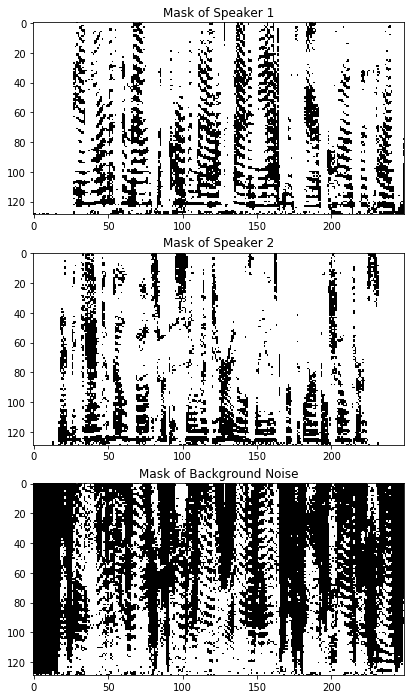

In [41]:
fn = '/scratch/near/2speakers_stft/wav8k/min/cv/mix/014a010f_0.097107_20fa010l_-0.097107.mat'
label = get_one_hot(None,fn)
b = get_feature(None,fn)
label = np.flip(label,1)
# b = np.flip(b,1)
f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,12))
ax1.imshow(label[:,:,0].T, cmap='binary', interpolation='nearest')
ax2.imshow(label[:,:,1].T, cmap='binary', interpolation='nearest')
ax3.imshow(label[:,:,2].T, cmap='binary', interpolation='nearest')
ax1.set_title("Mask of Speaker 1")
ax2.set_title("Mask of Speaker 2")
ax3.set_title("Mask of Background Noise")
plt.show()

# Test the Audio Quality Separated by Oracle Mask

In [42]:
a = loadmat(fn)
mask = get_one_hot(None,fn)
c = a['stft']*mask[:,:,1].T
t, x = istft(c)
savemat('/home/near/oracle_dc.mat',{'stft':c,'nsample':a['nsampl']})

In [44]:
ipd.Audio('/home/near/oracle_dc.wav') # load a local WAV file

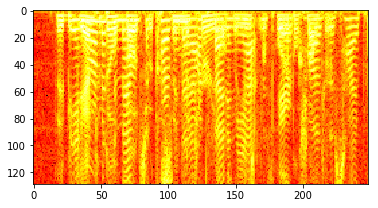

In [8]:
plt.imshow(b.T, cmap='hot', interpolation='nearest')
plt.show()

# Train The Model

In [10]:
num_epoc = 3
batch_size = 2
for epoc in range(num_epoc):
    f_list = glob.glob('/scratch/near/2speakers_stft/wav8k/min/cv/mix/*.mat')
    feat = None
    target = None
    i = 0
    model = MyNet(129,600,40,2)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
    while (len(f_list)>0 or feat is None or feat.shape[0]<batch_size*100):
        i+=1
        feat, target = generate_samples(f_list, batch_size, feat, target)
        inputs = feat[0:batch_size*100,:]
        labels = target[0:batch_size*100,:,:]
        inputs = inputs.reshape((batch_size,100,129))
        labels = labels.reshape((batch_size,100,129,3))
        inputs = Variable(torch.tensor(inputs, dtype=torch.float))
        labels = Variable(torch.tensor(labels, dtype=torch.long))
        feat = feat[batch_size:,:]
        target = target[batch_size:,:,:]
        out = model(inputs)
        optimizer.zero_grad()
        loss = loss_func(out.float(),labels.float(),40)
        loss.backward()
        optimizer.step()
        if i %100 ==0:
            print(loss)
            break
    break
    torch.save(model,'%d_model'%epoc)

tensor(0.2381)


# Load the trained model

In [12]:
m = torch.load('2_model')
b2 = b.reshape(1,249,129)
b2 = torch.tensor(b2,dtype=torch.float)
c = m(b2)
c2 = c.reshape(-1,40)
from sklearn.cluster import KMeans
d = c2.detach().numpy()
kmeans = KMeans(n_clusters=3, random_state=0).fit(d)

# Fit the K-Means Model by 100 audio files

In [18]:
f_list = glob.glob('/scratch/near/2speakers_stft/wav8k/min/cv/mix/*.mat')
a = []
for i in range(100):
    feat = None
    feat = get_feature(feat, f_list[i])
    feat = feat.reshape(1,feat.shape[0],129)
    feat = torch.tensor(feat,dtype=torch.float)
    c = m(feat)
    a.append(c)

In [21]:
points = None
for ele in a:
    ele = ele.reshape(-1,40)
    d = ele.detach().numpy()
    if points is None:
        points = d
    else:
        points = np.concatenate((points,d),axis = 0)

In [46]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(points)

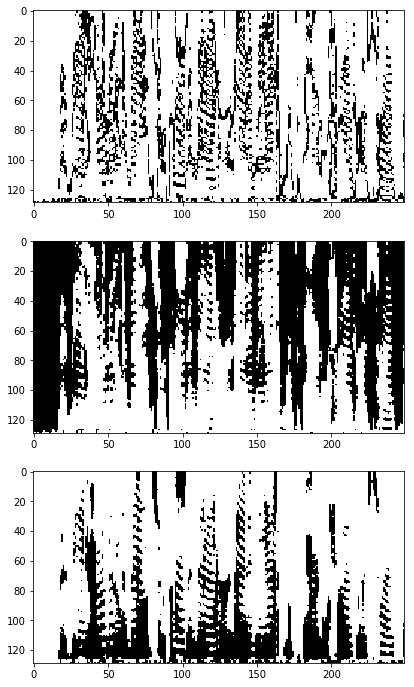

In [47]:
fn = '/scratch/near/2speakers_stft/wav8k/min/cv/mix/014a010f_0.097107_20fa010l_-0.097107.mat'
a = get_one_hot(None,fn)
b = get_feature(None,fn)
b2 = b.reshape(1,249,129)
b2 = torch.tensor(b2,dtype=torch.float)
c = m(b2)
c2 = c.reshape(-1,40)
d = c2.detach().numpy()
f = kmeans.predict(d)
f = f.reshape(249,129)
f1 = np.zeros(f.shape)
f2 = np.zeros(f.shape)
f3 = np.zeros(f.shape)
for i in range(f.shape[0]):
    for j in range(f.shape[1]):
        if f[i,j]==0:
            f1[i,j]=1
        elif f[i,j]==1:
            f2[i,j]=1
        else:
            f3[i,j]=1
f1 = np.flip(f1,1)
f2 = np.flip(f2,1)
f3 = np.flip(f3,1)
f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,12))
ax1.imshow(f1.T, cmap='binary', interpolation='nearest')
ax2.imshow(f2.T, cmap='binary', interpolation='nearest')
ax3.imshow(f3.T, cmap='binary', interpolation='nearest')
plt.show()

In [55]:
a = loadmat(fn)
mask = get_one_hot(None,fn)
c = a['stft']*f1.T
t, x = istft(c)
savemat('/home/near/test_dc.mat',{'stft':c,'nsample':a['nsampl']})

In [57]:
ipd.Audio('/home/near/test_dc.wav') # load a local WAV file

In [59]:
ipd.Audio('/scratch/near/2speakers/wav8k/min/cv/mix/014a010f_0.097107_20fa010l_-0.097107.wav') # load a local WAV file